![vki_logo](https://www.skywin.be/sites/default/files/logo-membres/vki_logo_blue_rectangular.jpg)
# MODULO: A package for Multiscale Proper Orthogonal Decomposition
### A Python tutorial by L. Schena and M. Mendez, von Karman Institute for Fluid Dynamics
This tutorial shows how to install the new Python package `modulo_vki` and run it. 
The theoretical background on modal analysis and a complete set of tutorials on the graphical user interface of MODULO can be found in MODULO's YouTube channel: [MODULO_YT_Channel](https://www.youtube.com/channel/UC-RoU7LisZSLy6o-EO4BUDA).

### In this tutorial: Time-Resolved PIV of an impinging jet flow

This Jupyter Notebook solves the exercise n.4
uploaded at [MODULO GitHub repo](https://github.com/mendezVKI/MODULO), and presented in [video 3](https://youtu.be/eG17tRQxqhk). The test case is taken from the article
["Multi-Scale Proper Orthogonal Decomposition of Complex Fluid Flows", by M.A. Mendez et al.](https://arxiv.org/abs/1804.09646),
and consists of a velocity field of an impinging jet flow measured via a Time-Resolved PIV.

Here is a snapshot of the flow field together with the spectra measured in different locations (see the original publication for more details):
![Exemplary snapshot of the velocity field from TR-PIV of an impinging jet flow](TR_piv_jet.png)




## Architecture Overview

The architecture of the package is the following:

![MODULO block scheme](modulo_blocks.png)


# MODULO - tutorial

To compute POD or mPOD, we will follow these steps:

0. Reading data (optional);
1. Initialize Data Matrix $\textbf{D}$;
2. Perform Temporal Correlation Matrix $\textbf{K}$;
3. Compute temporal and spatial basis for the decomposition of interest.

Moreover, the Memory Saving feature can be used, to limit the memory consumption of the above computations.


## Step 0. Reading Data

MODULO accepts data in a np.array format. We provide a couple of helper functions to convert .dat/.txt files
in such a format. Of course, if you have your numpy array already you can just skip this part.


In [15]:
from modulo.modulo import MODULO
from modulo.read_db import ReadData

In [16]:
import numpy as np 

FOLDER = "./Ex_4_TR_PIV_Jet"
# --- Component fields (N=2 for 2D velocity fields, N=1 for pressure fields)
N = 2 
# --- Number of mesh points
N_S = 6840
# --- Header, footer to be skipped during acquisition
H = 1
F = 0
# --- Read one sample snapshot (to get N_S)
Name = "./Ex_4_TR_PIV_jet/Res00001.dat"
Dat = np.genfromtxt(Name, skip_header=H, skip_footer=F)

D = ReadData._from_dat(folder='./Ex_4_TR_PIV_jet/', filename='Res%05d', N=2, N_S=2*Dat.shape[0],
                  h = H, f = F, c=2)


  0%|          | 3/2000 [00:00<01:11, 27.78it/s]


 
 Importing data... 
 



100%|██████████| 2000/2000 [01:07<00:00, 29.51it/s]


Now we have the matrix $D = (n_s, n_t)$ available for further computations.

## Step 1. Initialize Data Matrix $D$

MODULO provides a method called `DataMatrix` which allows the user to make some useful pre-processing operations:
- The mean field can be removed;
- If the Memory Saving feature is active, the Data Matrix $D$ is opportunely split in a number of partitions indicated
by the user, and then saved on disk.
- The data matrix $D$ can be saved on disk (as a `numpy array`).

MODULO uses as a default float type `float32`. However, if the user activates the Memory Saving feature, MODULO will ask to you if you want to switch to `float16` as an additional alleviation of the memory usage. 

You have to be cautious however that this comes with a price: 


In [17]:
a = 0.123456789

print(np.float32(a))
print(np.float16(a))

0.12345679
0.1235


That being said, we can start initialising MODULO, specifying that we would like to implement the Memory Saving feature with N_PARTITIONS = 11. 

In [18]:
# --- Initialize MODULO object
m = MODULO(data=D,
           MEMORY_SAVING=True,
           N_PARTITIONS=11)
# --- Check for D
D = m._data_processing()

print(D)

Memory Saving feature is active. Partitioning Data Matrix...

 Data Matrix has been successfully splitted. 

Saving the matrix D in ./MODULO_tmp/
None


Where print(D) command shows how, when Memory Saving feature is active, all matrixes are stored on disk only.

Finally, when Memory Saving is active, MODULO creates a folder called "MODULO_tmp" in your working directory in which every file will be stored. You can choose the directory of such a folder during modulo initialization - i.e.: 

> m = MODULO(data = mydata, MEMORY_SAVING = bool, FOLDER_OUT = `/your/favourite/folder/`)


## Step 2. Compute time-correlation matrix $K$

As a second step, common for whatever decomposition you are interested in, there is the computation of the temporal correlation matrix. 

If using the Memory Saving feature, the algorithm of such a computation is slightly different from the classical dot product, as illustrated by D. Ninni in his explanatory video: [MODULO Tutorial 8 : Memory Saving option for Limited RAM](https://youtu.be/LclxO1WTuao).

In [19]:
K = m._correlation_matrix()

  0%|          | 0/12 [00:00<?, ?it/s]


 Using Memory Saving feature...


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


As you can see, MODULO added an extra partition to the `N_PARTITIONS=11` we set. This is because `N_T % N_PARTITIONS !=0`: as a consequence we add an additional partition containing the remaining columns. 

Again, the correlation matrix is not saved in memory: 

In [20]:
print(K)

None


Out of curiosty, we can assess how much memory we are saving using such an approach, using `tracemalloc` package. 

In [21]:
D_raw = np.load("./MODULO_tmp/data_matrix/database.npz")['D'] 

import tracemalloc

tracemalloc.start()
K_try = np.dot(D_raw.T, D_raw)
current, _ = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Memory usage without Memory Saving active is {current / 10**6}MB")


tracemalloc.start()
K = m._correlation_matrix()
current, _ = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Memory usage with Memory Saving active is {current / 10**6}MB")


  0%|          | 0/12 [00:00<?, ?it/s]

Memory usage without Memory Saving active is 16.00095MB

 Using Memory Saving feature...


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]

Memory usage with Memory Saving active is 0.036203MB


The memory saving is of 3 order of magnitude. Not bad!

However, whatever method we choose to compute the correlation matrix with, the K matrix should be the same. This can be checked quickly: 

In [22]:
K_modulo = np.load("./MODULO_tmp/correlation_matrix/k_matrix.npz")['K']
print(np.allclose(K_try, K_modulo))

True


Now we have all we need for perform our decomposition of choice. 

## Step 3. Compute the decomposition of interest

Now we can finally compute our decomposition. Using MODULO this can be done in a black-box way, we simply have to call the proper functions: `compute_mPOD` and `compute_POD`. 

### Multiscale Proper Orthogonal Decomposition - mPOD

For instance, consider a mPOD decomposition. I will refer to the nomenclature present in the paper ["Multi-Scale Proper Orthogonal Decomposition of Complex Fluid Flows", by M.A. Mendez et al.](https://arxiv.org/abs/1804.09646). 

I'm assuming you already red this paper and followed the tutorial [MODULO Tutorial 3 : The Multiscale POD (mPOD)](https://www.youtube.com/watch?v=eG17tRQxqhk&list=PLEJZLD0-4PeKW6Ze984q08bNz28GTntkR&index=3). 

However, without diving into much detail, the main ingredients of such a decomposition are: 
- `F_V: np.array` = Frequency splitting vector (Remember that [$F_V$] = [$Hz$]); 
- `Keep: np.array` = Defines which scale to keep (`1` the scale is kept, `0` scale skipped);
- `Nf: np.array` = Kernel size for the FIR filter in each scale; 
- `boundaries: str` = In order to avoid 'edge effects' if the time correlation matrix is not periodic, several boundary conditions can be used.
- `MODE` = As a final step of this algorithm, the orthogonality is imposed via a QR-factorization. This parameter define how to perform such factorization


In [23]:
Keep = np.array([1, 1, 1, 1])
Nf = np.array([201, 201, 201, 201])
# --- Test Case Data:
# + Stand off distance nozzle to plate
H = 4 / 1000  
# + Mean velocity of the jet at the outlet
U0 = 6.5  
# + Input frequency splitting vector in dimensionless form (Strohual Number)
ST_V = np.array([0.1, 0.2, 0.25, 0.4])  
# + Frequency Splitting Vector in Hz
F_V = ST_V * U0 / H
# + Size of the extension for the BC (Check Docs)
Ex = 203  # This must be at least as Nf.
dt = 1/2000
boundaries = 'reflective'
MODE = 'reduced'
#K = np.load("./MODULO_tmp/correlation_matrix/k_matrix.npz")['K']
Phis, Psis, Sigmas = m.compute_mPOD(Nf, Ex, F_V, Keep, boundaries, MODE, dt, False)

  0%|          | 0/12 [00:00<?, ?it/s]


 Using Memory Saving feature...


  0%|          | 0/4 [00:00<?, ?it/s]

Filtering and Diagonalizing H scale: 

Filtering Largest Scale
Diagonalizing Largest Scale
325 Modes Estimated
Diagonalizing Largest Scale
324 Modes Estimated


 25%|██▌       | 1/4 [00:02<00:08,  2.82s/it]

162 Modes Estimated


 50%|█████     | 2/4 [00:04<00:03,  1.92s/it]

486 Modes Estimated


 75%|███████▌  | 3/4 [00:06<00:02,  2.12s/it]

699 Modes Estimated


100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


QR Polishing...
Done!


And that's it! Our mPOD decomposition $\Psi, \Phi$ and $\sigma$ are available. The same applies to computing the POD algorithm, using `compute_POD`. 

Taking over the script of the previous MODULO tutorials, the first six spectra can be plotted:

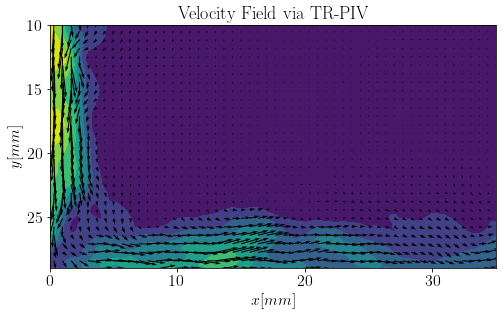

In [24]:
import os 
import matplotlib.pyplot as plt 
from Others import Plot_Field_TEXT

# --- Copying data matrix structure from previous tutorials: 
FOLDER='Ex_4_TR_PIV_Jet'
Name=FOLDER+os.sep+'Res%05d'%10+'.dat' # Check it out: print(Name)
n_s, Xg, Yg, Vxg, Vyg, X_S,Y_S=Plot_Field_TEXT(Name) 
nxny=n_s/2
n_t = 2000
####################### 1. CONSTRUCT THE DATA MATRIX D #################
# Initialize the data matrix D
D=np.zeros([n_s,n_t])

n_y,n_x=Yg.shape; nxny=n_x*n_y; n_s=nxny*2

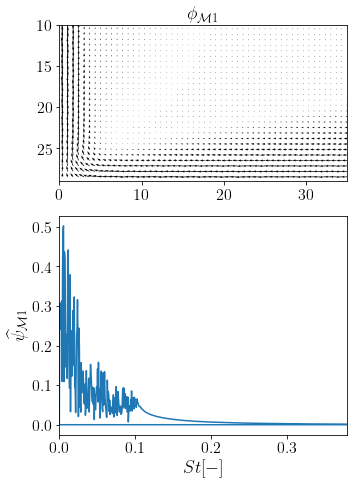

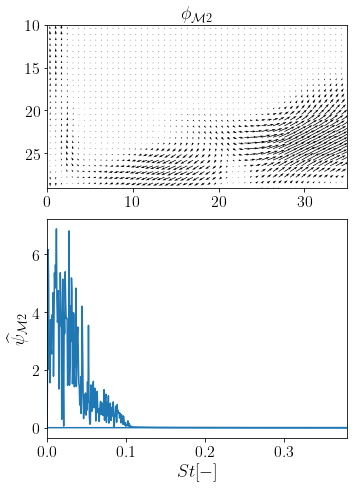

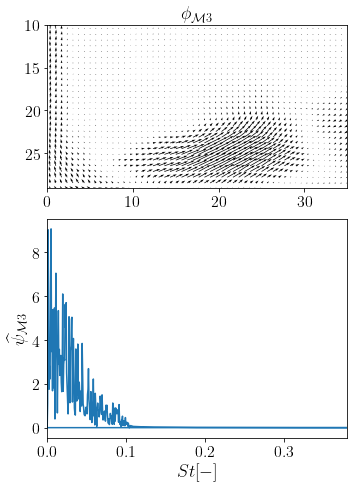

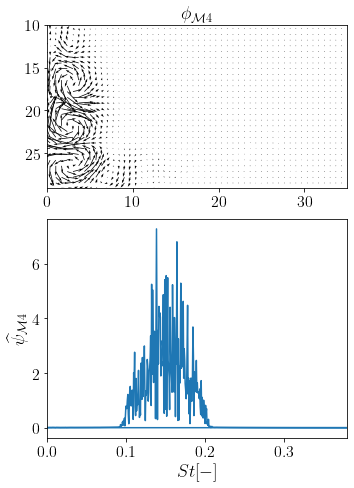

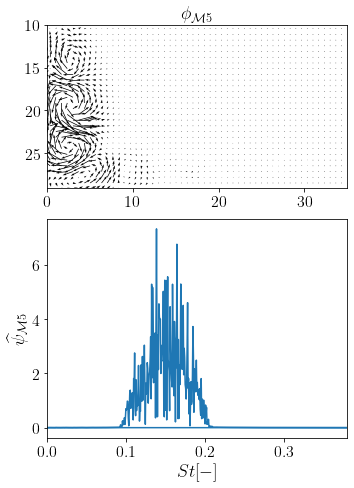

In [25]:
from Others import Plot_Field
%matplotlib inline

Fs = 1/dt
Phi_M = np.load("./MODULO_tmp/mPOD/sorted_phis.npz")['arr_0']
Psi_M = np.load("./MODULO_tmp/mPOD/sorted_psis.npz")['arr_0']

for j in range(1,6):
    fig, ax3= plt.subplots(figsize=(5,7))   
    ax=plt.subplot(2,1,1)
    V_X=Phi_M[0:nxny,j-1]
    V_Y=Phi_M[nxny::,j-1]
    Plot_Field(X_S,Y_S,V_X,V_Y,True,2,0.8)
    ax.set_aspect('equal') # Set equal aspect ratio
    ax.set_xticks(np.arange(0,40,10))
    ax.set_yticks(np.arange(10,30,5))
    ax.set_xlim([0,35])
    ax.set_ylim([10,29])
    ax.invert_yaxis() # Invert Axis for plotting purpose
    String_y='$\phi_{\mathcal{M}'+str(j)+'}$'
    plt.title(String_y,fontsize=18)
    plt.tight_layout(pad=1, w_pad=0.5, h_pad=1.0)

    ax=plt.subplot(2,1,2)
    Signal=Psi_M[:,j-1]
    s_h=np.abs((np.fft.fft(Signal-Signal.mean())))
    Freqs=np.fft.fftfreq(int(n_t))*Fs
    plt.plot(Freqs*(4/1000)/6.5,s_h,'-',linewidth=1.5)
    plt.xlim(0,0.38)    
    plt.xlabel('$St[-]$',fontsize=18)
    String_y='$\widehat{\psi}_{\mathcal{M}'+str(j)+'}$'
    plt.ylabel(String_y,fontsize=18)
    plt.tight_layout(pad=1, w_pad=0.5, h_pad=1.0) 

In [26]:
# --- Computing POD as a comparison 

Phi_P, Psi_P, Sigma_P = m.compute_POD()

  0%|          | 0/12 [00:00<?, ?it/s]


 Using Memory Saving feature...


100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Saving POD temporal basis


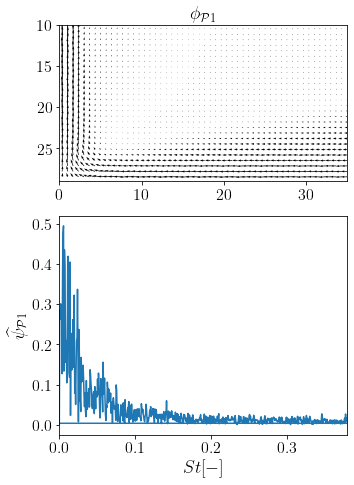

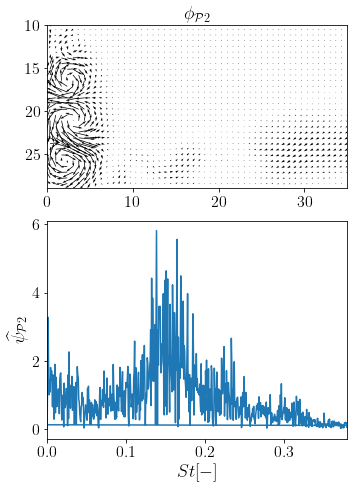

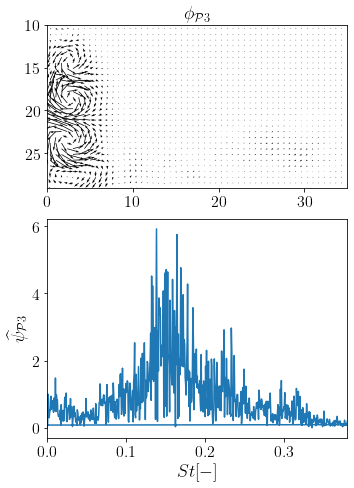

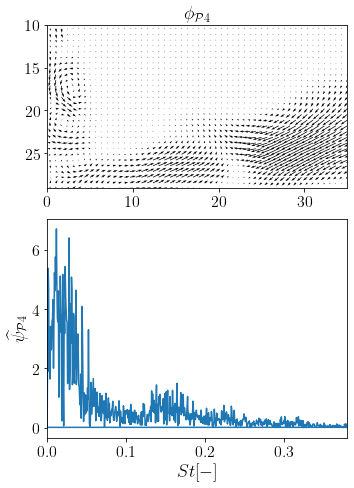

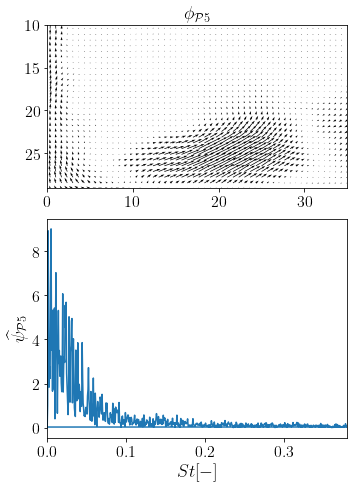

In [27]:
Phi_P_matrix = np.zeros((13680, 2000))

for n in range(2000):
    Phi_P_matrix[:, n] = np.load(f'./MODULO_tmp/POD/phi_{n + 1}.npz')['phi_p']

for j in range(1,6):
    fig, ax3= plt.subplots(figsize=(5,7))   
    ax=plt.subplot(2,1,1)
    V_X=Phi_P_matrix[0:nxny,j-1]
    V_Y=Phi_P_matrix[nxny::,j-1]
    Plot_Field(X_S,Y_S,V_X,V_Y,True,2,0.8)
    ax.set_aspect('equal') # Set equal aspect ratio
    ax.set_xticks(np.arange(0,40,10))
    ax.set_yticks(np.arange(10,30,5))
    ax.set_xlim([0,35])
    ax.set_ylim([10,29])
    ax.invert_yaxis() # Invert Axis for plotting purpose
    String_y='$\phi_{\mathcal{P}'+str(j)+'}$'
    plt.title(String_y,fontsize=18)
    plt.tight_layout(pad=1, w_pad=0.5, h_pad=1.0)

    ax=plt.subplot(2,1,2)
    Signal=Psi_P[:,j-1]
    s_h=np.abs((np.fft.fft(Signal-Signal.mean())))
    Freqs=np.fft.fftfreq(int(n_t))*Fs
    plt.plot(Freqs*(4/1000)/6.5,s_h,'-',linewidth=1.5)
    plt.xlim(0,0.38)    
    plt.xlabel('$St[-]$',fontsize=18)
    String_y='$\widehat{\psi}_{\mathcal{P}'+str(j)+'}$'
    plt.ylabel(String_y,fontsize=18)
    plt.tight_layout(pad=1, w_pad=0.5, h_pad=1.0) 

# Towards customization: accessing `MODULO` methods

We have decomposed our dataset in a black-box manner - i.e.: without caring of the inner mechanism that is going on and, more interestingly, neglecting intermediate results. 

You can customize your decomposition, accessing `MODULO.methods()`: 

In [ ]:
def my_decomposition_algo(example): 
    """
    An example of a customized decomposition algorithm
    """
    PSIs = another_temporal_decomposition_I_want_to_test(args)
    Phis, Psis, Sigmas = m.spatial_basis_mPOD(PSIs, args)
    return Phis, Psis, Sigmas

# `MODULO`: What's next?

- Proper documentation; 
- What about tensors? Explore `tensorflow` capabilities in matricial applications;
- ...? 



# Farewell

This closes this brief overview of `MODULO` Python package capabilities. 

For any suggestion, bug or whatever, feel free to drop by the [MODULO GitHub repository](https://github.com/mendezVKI/MODULO) and open an issue. 

See you soon, 
Lorenzo